# Clustering Customer Data


## <font color=blue>Import needed modules</font>

In [ ]:
#general libraries always needed
import pandas as pd
import numpy as np
import math

#plotting required modules
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator, FixedFormatter

#sklearn clustering / unsupervised learning modules
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, classification_report
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
# Smote
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from imblearn.pipeline import Pipeline  #
#sklearn modules for preprocessing and transformation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as PL
from sklearn.decomposition import PCA


#give yourself the opportunity to visualize the pipeline and models
from sklearn import set_config
set_config(display='diagram')


## <font color=blue>Function Definitions</font>

In [ ]:
#function to create an Avg. Distance to Nearest Neighbor plt
def nn_avg_distance(X):
    plt.figure(figsize=(10,5))
    nn = NearestNeighbors(n_neighbors=15).fit(X)
    distances, idx = nn.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.xlabel("Instances", fontsize=14)
    plt.ylabel("Distances", fontsize=14)
    plt.title("Average Distance to Nearset Neighbor")
    plt.show()

In [ ]:
#function to create a silhouette diagram
#requires the model, the independent value (i.e. X) used to fit the model, and a list of k values to plot

def inertia_silhouette_plot( X, k_values):

    #iterate through different k values and collect inertia values and silhouette scores
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
                for k in range(1, max(k_values)+1)]
    inertias = [model.inertia_ for model in kmeans_per_k]
    silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

    #print the silhouette scores and k values
    plt.plot(inertias)
    plt.ylabel("Inertia", fontsize=14)
    plt.xlabel("k Value", fontsize=14)
    plt.show()
    print("-"*80)
    #create the plot's figure
    plt.figure(figsize=(10, len(k_values)*3))

    ct = 0 #temp counter variable

    #build a subplot for each value of k
    for k in k_values:

        #create the subplot
        ct +=1
        plt.subplot(math.ceil(len(k_values)/2), 2, ct)

        #get the predictions and silhouette value
        y_pred = kmeans_per_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(X, y_pred)

        #create the bars for each cluster
        padding = len(X) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = mpl.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

       #plot the silhouette line
        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")

        #chart title
        plt.title(f"k={k} --- {silhouette_scores[k - 2]:.2}", fontsize=16)

        #add a y label for each row and an x axis label for the last 2 graphs
        if ct%2 == 1:
            plt.ylabel("Cluster")
        if ct == len(k_values) or ct==len(k_values)-1:
            #plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")

    #plot
    plt.show()

In [ ]:
#function to create a 2 dimmensional representation of data using tSNE
#needs the independent data as well as Y label data OR prediction
def tsne_plot(X, y=None, labels=None):
    X_tsne = TSNE(random_state=42).fit_transform(X)
    plt.figure(1, facecolor='white', figsize=(10, 10))
    if y is None:
        p = plt.scatter( X_tsne[:,0], X_tsne[:,1])
    else:
        p = plt.scatter( X_tsne[:,0], X_tsne[:,1], c=y, cmap = cm.Paired)
        if not labels is None:
            plt.legend(handles=p.legend_elements()[0], labels=list(labels), loc="best", fontsize=10)
    plt.title('T-SNE',fontsize=14)
    plt.xlabel("Dimension 1", fontsize=14)
    plt.ylabel("Dimension 2", fontsize=14)
    plt.show()

In [ ]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file,sourcePath,compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")## <font color=blue>Source data</font>

## <font color=blue>Source Data</font>

In [ ]:
#create a dataframe with the data from the CSV file
data = pd.read_csv('https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt8/FREDWeighted.csv')
USRecession_data = pd.read_csv('https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt8/USRecessionData.csv')


In [ ]:
USRecession_data.head()

,observation_date,USREC
0,1854-12-01,1
1,1855-01-01,0
2,1855-02-01,0
3,1855-03-01,0
4,1855-04-01,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Columns: 127 entries, sasdate to VIXCLSx
dtypes: float64(126), object(1)
memory usage: 786.9+ KB


In [ ]:
for column in data.columns:
    print(column)

sasdate
RPI
W875RX1
DPCERA3M086SBEA
CMRMTSPLx
RETAILx
INDPRO
IPFPNSS
IPFINAL
IPCONGD
IPDCONGD
IPNCONGD
IPBUSEQ
IPMAT
IPDMAT
IPNMAT
IPMANSICS
IPB51222S
IPFUELS
CUMFNS
HWI
HWIURATIO
CLF16OV
CE16OV
UNRATE
UEMPMEAN
UEMPLT5
UEMP5TO14
UEMP15OV
UEMP15T26
UEMP27OV
CLAIMSx
PAYEMS
USGOOD
CES1021000001
USCONS
MANEMP
DMANEMP
NDMANEMP
SRVPRD
USTPU
USWTRADE
USTRADE
USFIRE
USGOVT
CES0600000007
AWOTMAN
AWHMAN
HOUST
HOUSTNE
HOUSTMW
HOUSTS
HOUSTW
PERMIT
PERMITNE
PERMITMW
PERMITS
PERMITW
ACOGNO
AMDMNOx
ANDENOx
AMDMUOx
BUSINVx
ISRATIOx
M1SL
M2SL
M2REAL
BOGMBASE
TOTRESNS
NONBORRES
BUSLOANS
REALLN
NONREVSL
CONSPI
S&P 500
S&P div yield
S&P PE ratio
FEDFUNDS
CP3Mx
TB3MS
TB6MS
GS1
GS5
GS10
AAA
BAA
COMPAPFFx
TB3SMFFM
TB6SMFFM
T1YFFM
T5YFFM
T10YFFM
AAAFFM
BAAFFM
TWEXAFEGSMTHx
EXSZUSx
EXJPUSx
EXUSUKx
EXCAUSx
WPSFD49207
WPSFD49502
WPSID61
WPSID62
OILPRICEx
PPICMM
CPIAUCSL
CPIAPPSL
CPITRNSL
CPIMEDSL
CUSR0000SAC
CUSR0000SAD
CUSR0000SAS
CPIULFSL
CUSR0000SA0L2
CUSR0000SA0L5
PCEPI
DDURRG3M086SBEA
DNDGRG3M086SBEA
DSERRG

In [ ]:
data.shape

(793, 127)

## <font color=blue>Prepare Data</font>

In [ ]:
# Merge the dataframes
merged_data = pd.merge(data, USRecession_data, left_on='sasdate', right_on = 'observation_date', how = 'inner')#,how='left')

# Set the index to the date field
merged_data.set_index('sasdate', inplace=True)
merged_data = merged_data.drop(columns='observation_date')
# Display the merged data with the date as index
merged_data.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,USREC
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1959-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1959-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1959-04-01,0.566221,0.604562,0.542095,0.805500,0.545982,1.876761,1.145233,0.948852,0.774217,1.049791,...,0.226556,0.469484,0.272109,0.653595,NaN,0.741198,0.504147,-0.947853,NaN,0
1959-05-01,0.631350,0.706424,0.599505,0.788532,0.562707,1.720727,0.968538,0.981523,0.687593,1.566645,...,0.232779,0.467290,0.271003,0.487805,NaN,1.425777,0.943243,-1.115993,NaN,0


In [ ]:
# Delete rows with more than 5 missing values
merged_data = merged_data[merged_data.isnull().sum(axis=1) <= 5]
# merged_data = merged_data.dropna(thresh=merged_data.shape[1] - 5)

# Delete columns with more than 10% missing values
threshold = int(0.9 * len(merged_data))  # Keep columns with at least 90% non-NaN
merged_data = merged_data.dropna(axis=1, thresh=threshold)

# Replace any value in the dataframe that is inf (for infinity) with NaN (not a number).
merged_data = merged_data.replace([np.inf, -np.inf], np.nan)


In [ ]:
# Create X and y
X_merged = merged_data.drop(columns='USREC')
y_merged = merged_data['USREC']


### Build Transformation Pipeline

In [ ]:
non_numeric_cols = X_merged.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", list(non_numeric_cols))

numeric_cols = X_merged.select_dtypes(include=['number']).columns
print("Numeric columns:", list(numeric_cols))

#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), #because no missing values, not used
 ('power_transformer', PowerTransformer() ),
])


#define the pipeline process for the data set
col_pipeline = ColumnTransformer( [
    ('num', num_pipeline, numeric_cols)
])

#build a top-level pipeline that in the future will allow for more sophisicated data preparation steps including other ML models
full_pipeline=Pipeline([
    ('col_pipeline', col_pipeline),
    #('pca', PCA(n_components=.95))
    ('smote', SMOTE(random_state=42))
])
full_pipeline2=PL([ #Incase we want to compare the effects of SMOTE here
    ('col_pipeline', col_pipeline),
    #('pca', PCA(n_components=.95))
    #('smote', SMOTE(random_state=42))
])

Non-numeric columns: []
Numeric columns: ['RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPMANSICS', 'IPB51222S', 'IPFUELS', 'CUMFNS', 'HWI', 'HWIURATIO', 'CLF16OV', 'CE16OV', 'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV', 'CLAIMSx', 'PAYEMS', 'USGOOD', 'CES1021000001', 'USCONS', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'SRVPRD', 'USTPU', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'AWHMAN', 'HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW', 'AMDMNOx', 'AMDMUOx', 'BUSINVx', 'ISRATIOx', 'M1SL', 'M2SL', 'M2REAL', 'BOGMBASE', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'CONSPI', 'S&P 500', 'S&P div yield', 'S&P PE ratio', 'FEDFUNDS', 'CP3Mx', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'COMPAPFFx', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5

In [ ]:
X_s, y_s = full_pipeline.fit_resample(X_merged, y_merged)

# Step 6: Check the result
print("Original shape:", X_merged.shape, y_merged.value_counts().to_dict())
print("Resampled shape:", X_s.shape, dict(pd.Series(y_s).value_counts()))

Original shape: (778, 123) {0: 683, 1: 95}
Resampled shape: (1366, 123) {0: np.int64(683), 1: np.int64(683)}


In [ ]:
#Pipeline without smote (oversampling)
X = full_pipeline2.fit_transform(X_merged)

#Check the result
print("Original shape:", X_merged.shape, y_merged.value_counts().to_dict())
print("Data shape after the pipeline without smote:", X.shape, dict(pd.Series(y_merged).value_counts()))

Original shape: (778, 123) {0: 683, 1: 95}
Data shape after the pipeline without smote: (778, 123) {0: np.int64(683), 1: np.int64(95)}


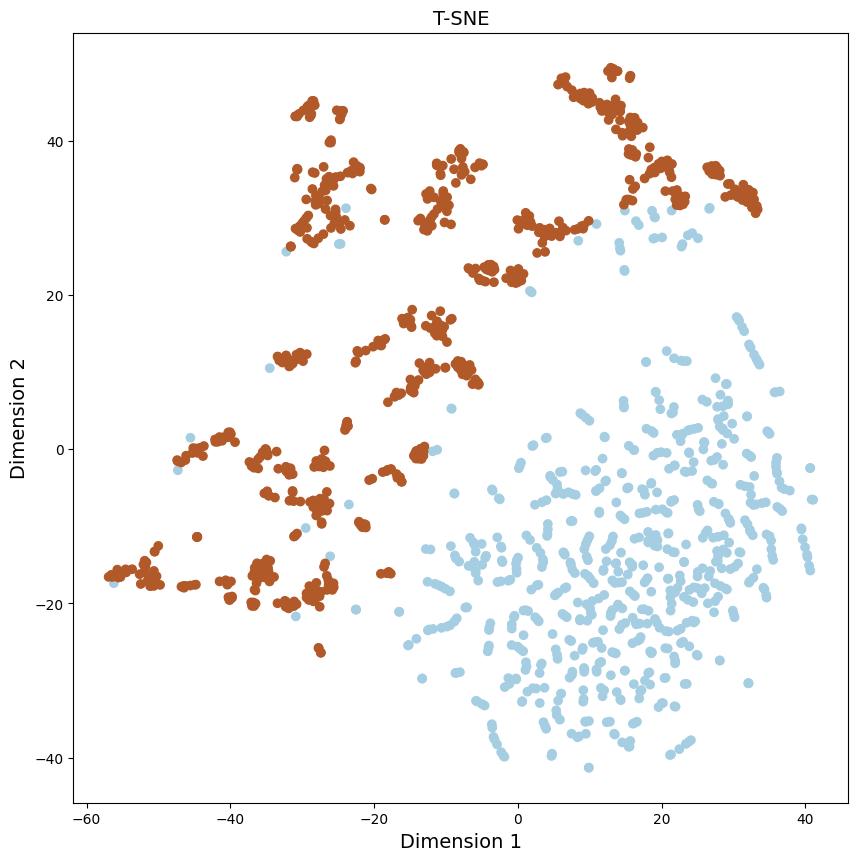

In [ ]:
# --- Preparing data for t-SNE ---, visualizing the data after resampling

tsne_plot(X_s, y_s)

## <font color=blue>K-Means

Let's train a K-Means cluster on this data set. It will try to find each blob's center and assign each instance to the closest blob.

### <font color=red>How many clusters?

#### Plot Inertia & Silhouette Coefficient

To determine an ideal <i>k</i> value, need to look where there is low inertia (mean square error between each instance & centroid) and a high (close to 1) silhouette coefficient (proximity to cluster boundries)

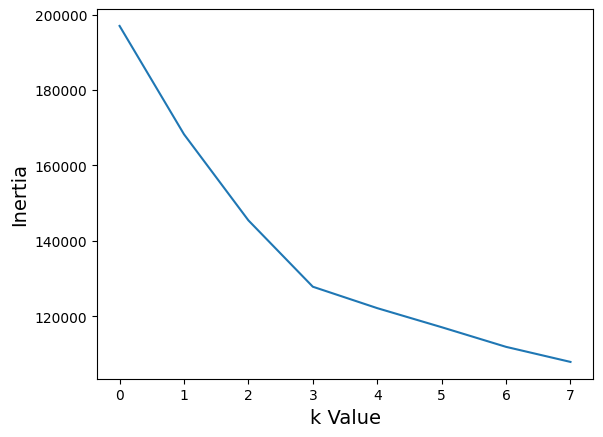

--------------------------------------------------------------------------------


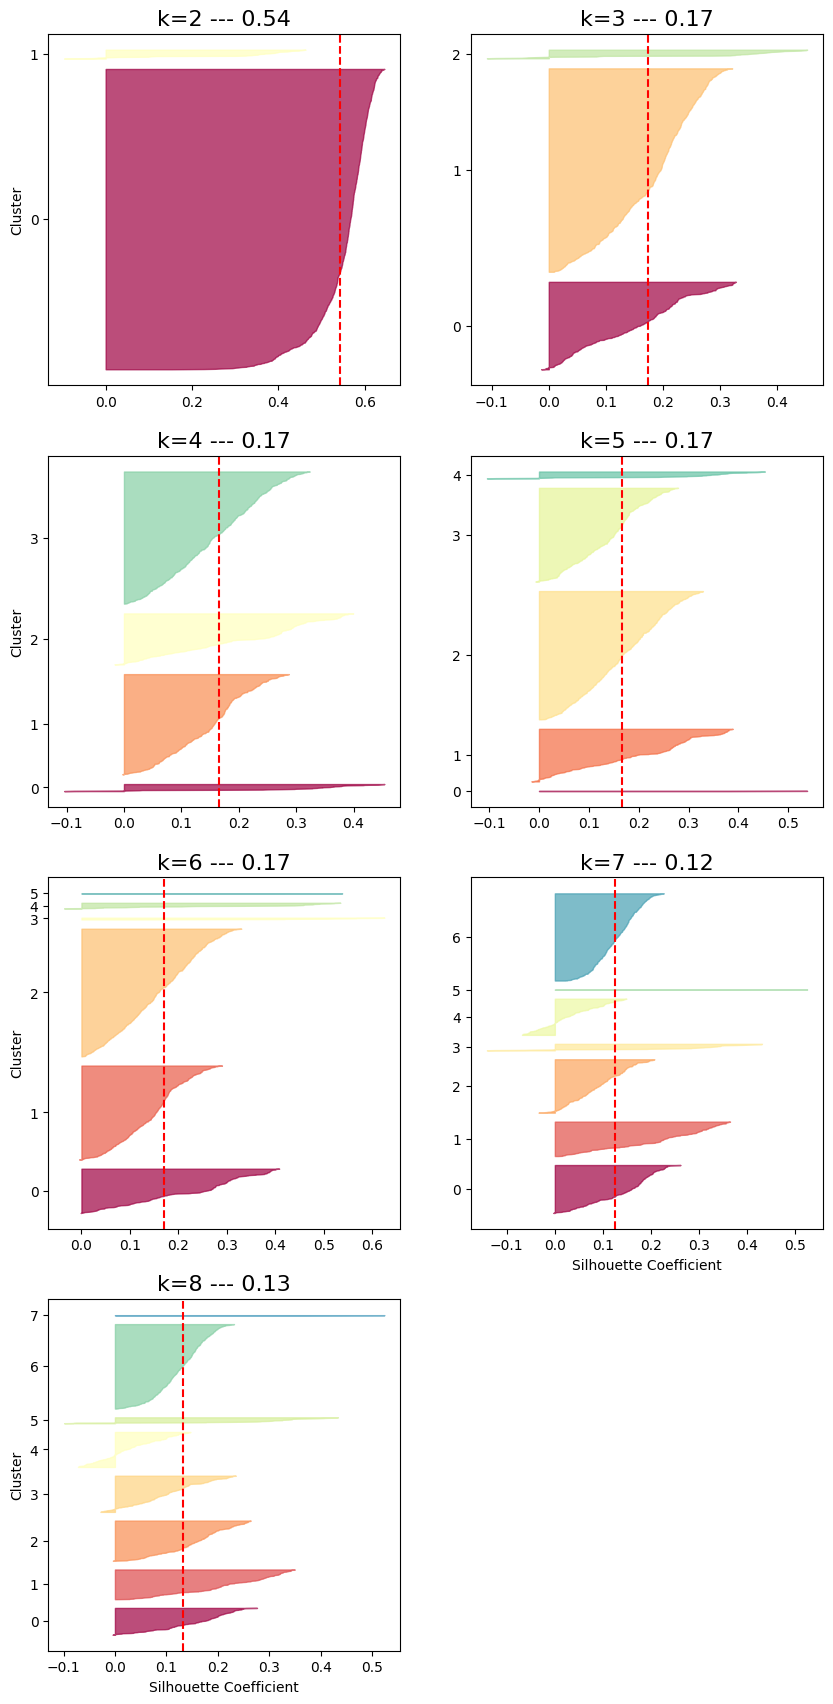

In [ ]:
#use this function to evaluate your X data across different k values
#NOTE: this function can take a little time especially if your k value list has numbers > 20
inertia_silhouette_plot(X_s, [2, 3, 4, 5, 6, 7, 8])

### Build Model and Predict

In [ ]:
k = 4

#create the model
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

#fit the model and predict y values (i.e. cluster value)
y_pred_kmean_4= kmeans.fit_predict(X_s)

Each instance was assigned to one of the k clusters

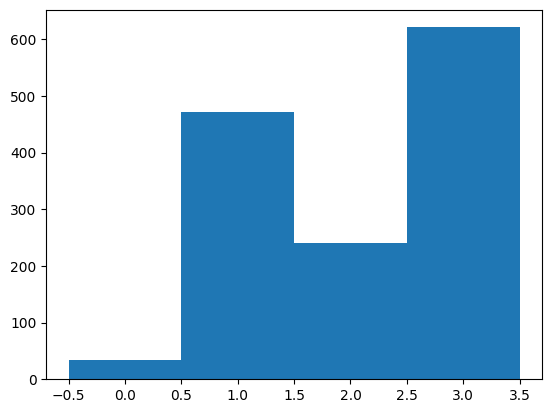

In [ ]:
#plot the number of instances in each of the created clusters
plt.hist(y_pred_kmean_4, bins=range(len(set(y_pred_kmean_4))+1), align='left')
plt.show()

### Analyze Clusters

In [ ]:
#save the predictions of each instance to a column called KMeans
X_merged[ "KMeans_4_S"] = y_pred_kmean_4[:778]

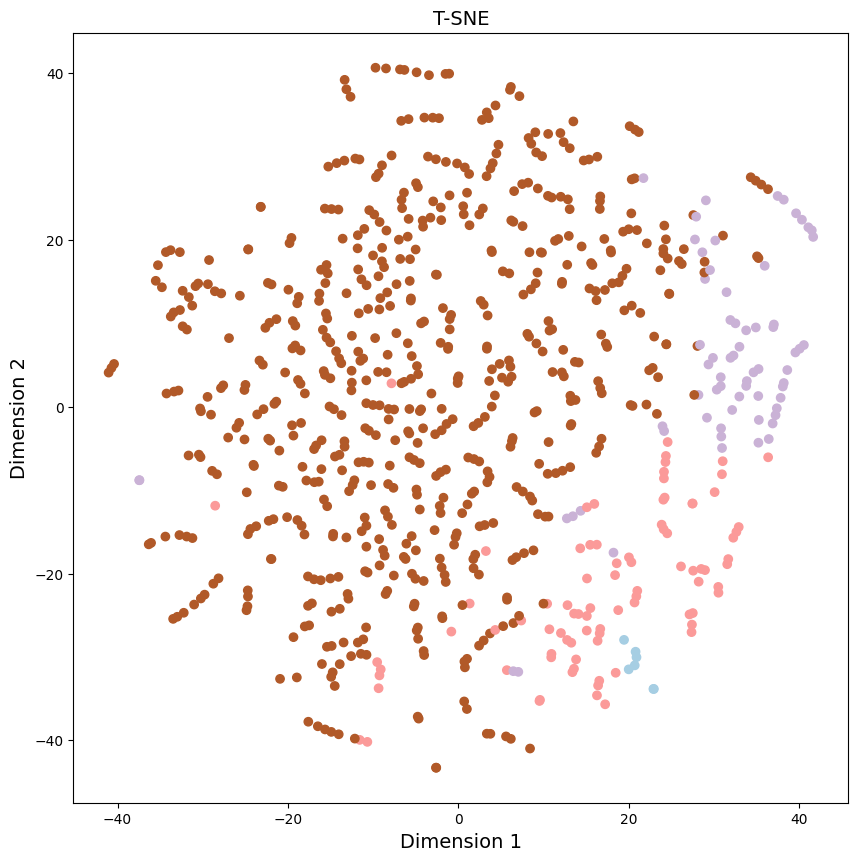

In [ ]:
tsne_plot(X, y_pred_kmean_4[:778])

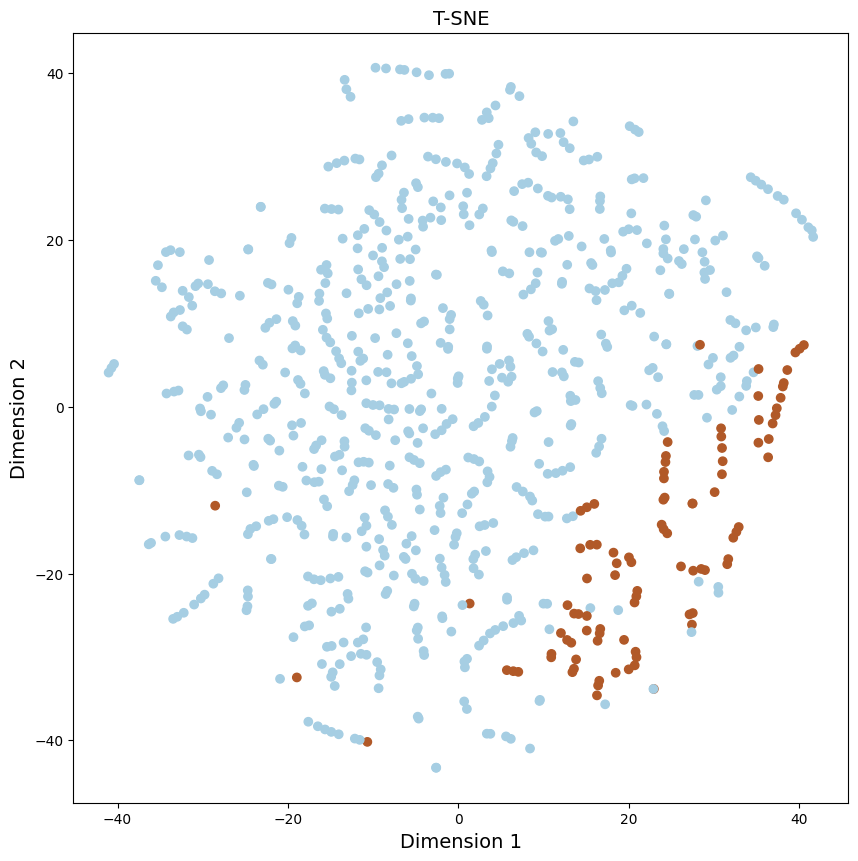

In [ ]:
tsne_plot(X, y_merged)

In [ ]:
X_merged.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,KMeans_4_S
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-04-01,0.217000,0.181274,1.144257,-0.125883,0.963593,-0.852720,-0.226793,-0.114339,-0.113860,-1.146860,...,0.146506,0.150150,0.518807,0.156495,2.203269,0.996106,0.829600,-1.758171,NaN,1
1960-05-01,0.259227,0.232293,0.302686,-1.616331,0.326743,-0.598588,0.152058,0.229604,0.460786,-0.387620,...,0.178049,0.149477,0.643501,0.000000,-2.233333,1.248423,0.978035,-0.750197,NaN,1
1960-06-01,0.221856,0.194058,-0.176169,-0.434232,0.317915,-0.717204,-0.114302,-0.114865,0.191831,-0.079024,...,0.222434,0.000000,-0.619579,0.000000,-2.233333,1.560265,1.350750,-0.159934,NaN,1
1960-07-01,0.165743,0.137180,-0.612332,-0.979686,-0.872057,-0.570900,-0.380445,-0.344476,-0.342849,-1.306322,...,0.234652,0.298954,0.638570,0.000000,-2.233333,1.191418,1.422327,0.713661,NaN,1
1960-08-01,0.031939,-0.028673,0.029163,0.014053,-0.267219,-0.571412,-0.643178,-0.570153,-0.454503,-1.254916,...,0.202404,0.297619,0.505051,0.155763,1.393355,0.903601,1.485908,0.648432,NaN,1


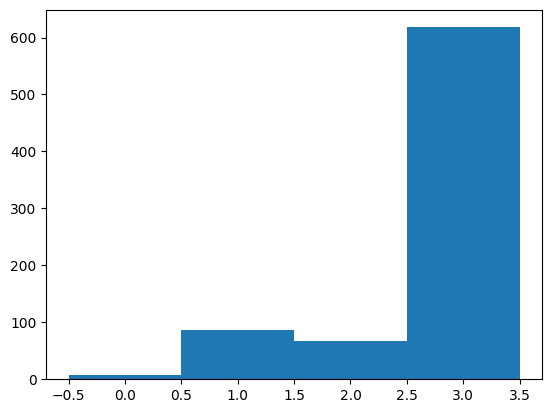

In [ ]:
#plot the number of instances in each of the created clusters
plt.hist(y_pred_kmean_4[:778], bins=range(len(set(y_pred_kmean_4[:778]))+1), align='left')
plt.show()

In [ ]:
# Create the new column 'KMean_Pred' and initialize it with 0
X_merged['KMean_Pred_4_S'] = 0

X_merged.loc[X_merged['KMeans_4_S'] == 0, 'KMean_Pred_4_S'] = 1
X_merged.loc[X_merged['KMeans_4_S'] == 1, 'KMean_Pred_4_S'] = 1
X_merged.loc[X_merged['KMeans_4_S'] == 2, 'KMean_Pred_4_S'] = 1

# Now 'KMean_Pred' has 1 for the smaller cluster and 0 for others
X_merged.head()


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,KMeans_4_S,KMean_Pred_4_S
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-04-01,0.217000,0.181274,1.144257,-0.125883,0.963593,-0.852720,-0.226793,-0.114339,-0.113860,-1.146860,...,0.150150,0.518807,0.156495,2.203269,0.996106,0.829600,-1.758171,NaN,1,1
1960-05-01,0.259227,0.232293,0.302686,-1.616331,0.326743,-0.598588,0.152058,0.229604,0.460786,-0.387620,...,0.149477,0.643501,0.000000,-2.233333,1.248423,0.978035,-0.750197,NaN,1,1
1960-06-01,0.221856,0.194058,-0.176169,-0.434232,0.317915,-0.717204,-0.114302,-0.114865,0.191831,-0.079024,...,0.000000,-0.619579,0.000000,-2.233333,1.560265,1.350750,-0.159934,NaN,1,1
1960-07-01,0.165743,0.137180,-0.612332,-0.979686,-0.872057,-0.570900,-0.380445,-0.344476,-0.342849,-1.306322,...,0.298954,0.638570,0.000000,-2.233333,1.191418,1.422327,0.713661,NaN,1,1
1960-08-01,0.031939,-0.028673,0.029163,0.014053,-0.267219,-0.571412,-0.643178,-0.570153,-0.454503,-1.254916,...,0.297619,0.505051,0.155763,1.393355,0.903601,1.485908,0.648432,NaN,1,1


In [ ]:
print(classification_report(y_merged, X_merged['KMean_Pred_4_S']))


              precision    recall  f1-score   support

           0       1.00      0.90      0.95       683
           1       0.59      0.99      0.74        95

    accuracy                           0.91       778
   macro avg       0.79      0.95      0.84       778
weighted avg       0.95      0.91      0.92       778



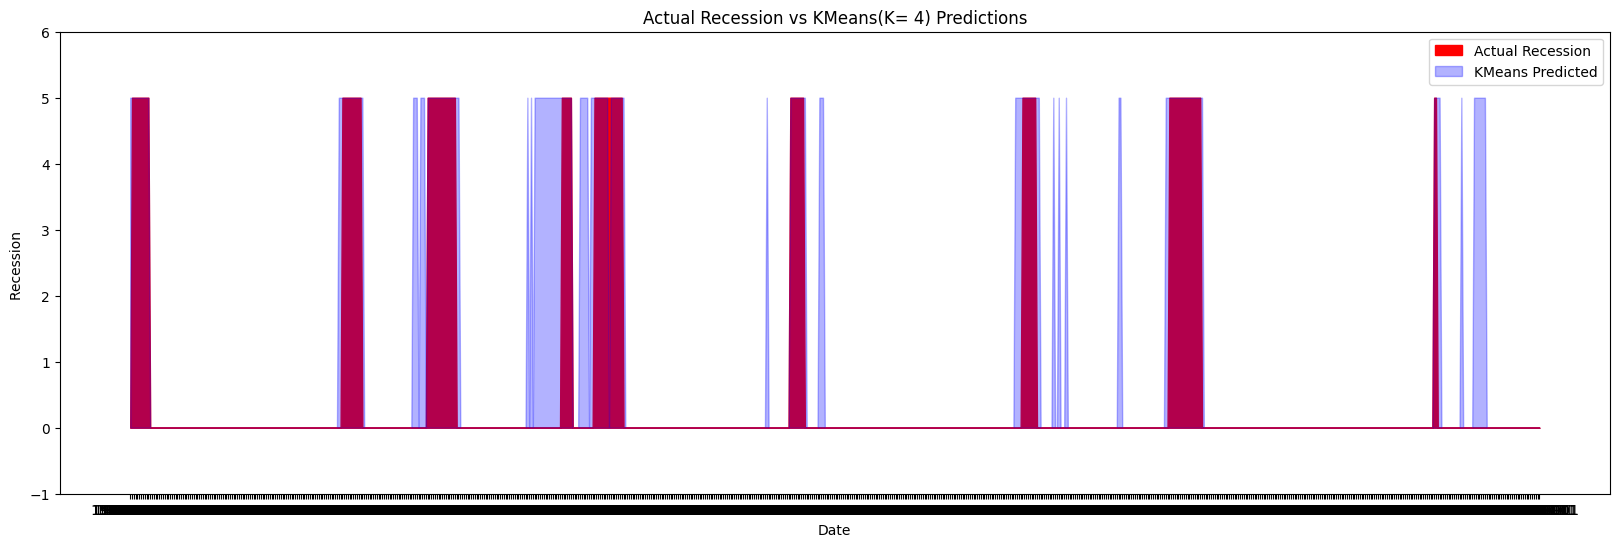

In [ ]:
plt.figure(figsize=(20,6))
plt.ylim([-1, 6])

# Actual recession periods (scaled for visibility)
plt.fill_between(merged_data.index, merged_data.USREC * 5, color="red", label="Actual Recession")

# KMeans predicted values (assumed to be 0 or 1, or possibly cluster labels)
#plt.plot(X_merged.index, X_merged['KMean_Pred'], color="blue", label="KMeans Predicted")#, linewidth=2)
plt.fill_between(X_merged.index, X_merged['KMean_Pred_4_S']*5, color="blue", alpha=0.3, label="KMeans Predicted")
# Optional: Add titles and labels
plt.title("Actual Recession vs KMeans(K= 4) Predictions")
plt.xlabel("Date")
plt.ylabel("Recession ")
plt.legend()
plt.grid(False)

plt.show()

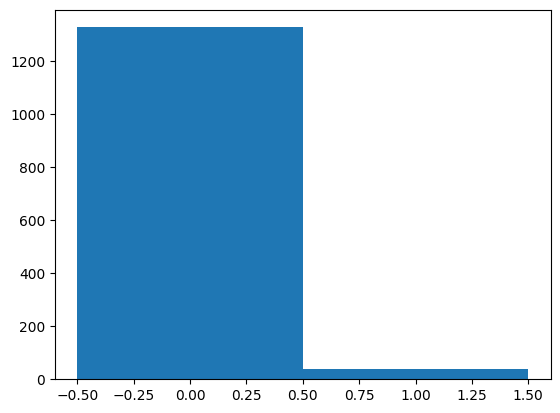

Number of samples in clusters for oversampled data: (1366, 123) {0: np.int64(1326), 1: np.int64(40)}


In [ ]:
#determine number of clusters
k = 2

#create the model
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

#fit the model and predict y values (i.e. cluster value)
y_pred_kmean_2_s = kmeans.fit_predict(X_s)
#plot the number of instances in each of the created clusters
plt.hist(y_pred_kmean_2_s, bins=range(len(set(y_pred_kmean_2_s))+1), align='left')
plt.show()

print("Number of samples in clusters for oversampled data:", X_s.shape, dict(pd.Series(y_pred_kmean_2_s).value_counts()))



In [ ]:
X_merged['KMeans_2_s'] = y_pred_kmean_2_s[:778]

In [ ]:
cluster_count_kmean_2 = X_merged['KMeans_2_s'].value_counts()
print(cluster_count_kmean_2)


KMeans_2_s
0    769
1      9
Name: count, dtype: int64


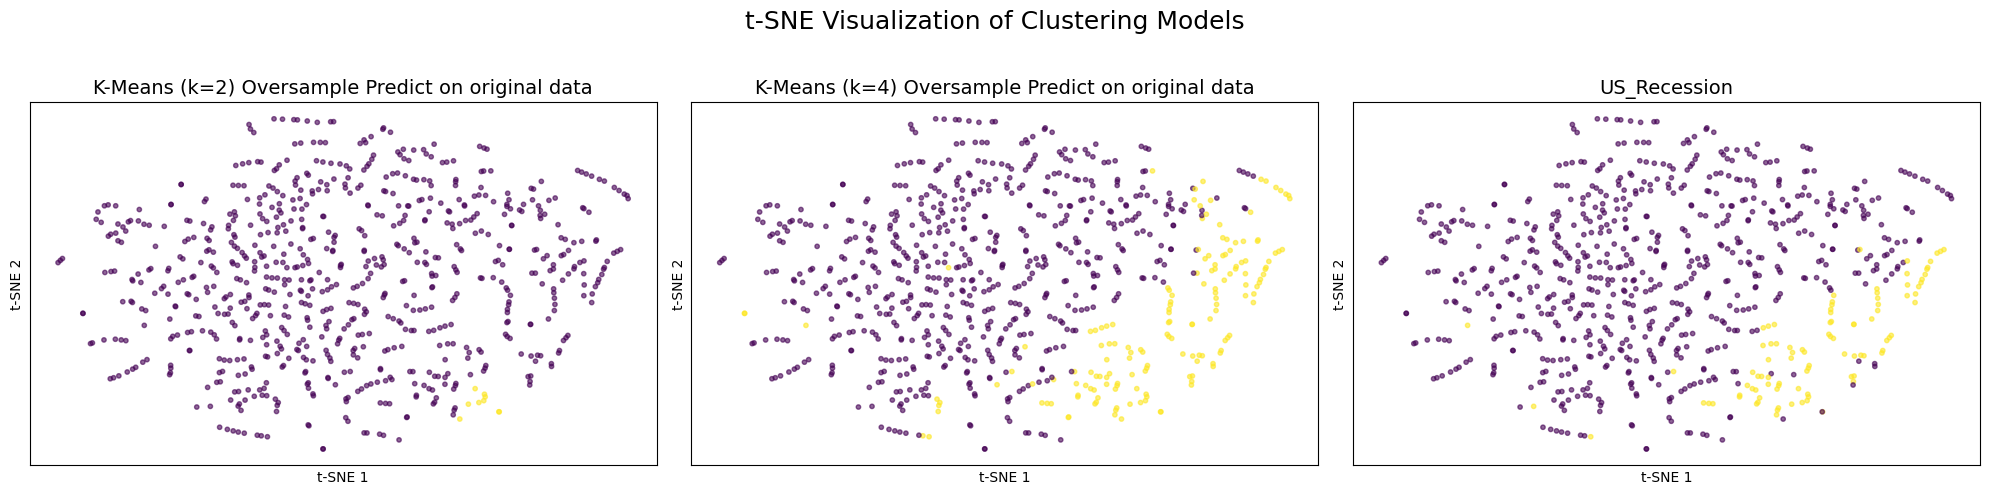

In [ ]:
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

# Define all clustering labels and titles
cluster_results = {
    "K-Means (k=2) Oversample Predict on original data": X_merged['KMeans_2_s'],
    "K-Means (k=4) Oversample Predict on original data": X_merged['KMean_Pred_4_S'],
    "US_Recession": y_merged
}

# Create subplots
plt.figure(figsize=(20, 5))

for i, (title, labels) in enumerate(cluster_results.items(), 1):
    plt.subplot(1, 3, i)

    color_map = {
    0: '#1f77b4',  # tab:blue
    1: '#d62728'   # tab:red
    }

    # Convert label array to color list
    color_list = labels.map(color_map)
    # scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color_list, s=10, alpha=0.6)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, s=10, alpha=0.6)
    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.xticks([])
    plt.yticks([])

plt.suptitle("t-SNE Visualization of Clustering Models", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


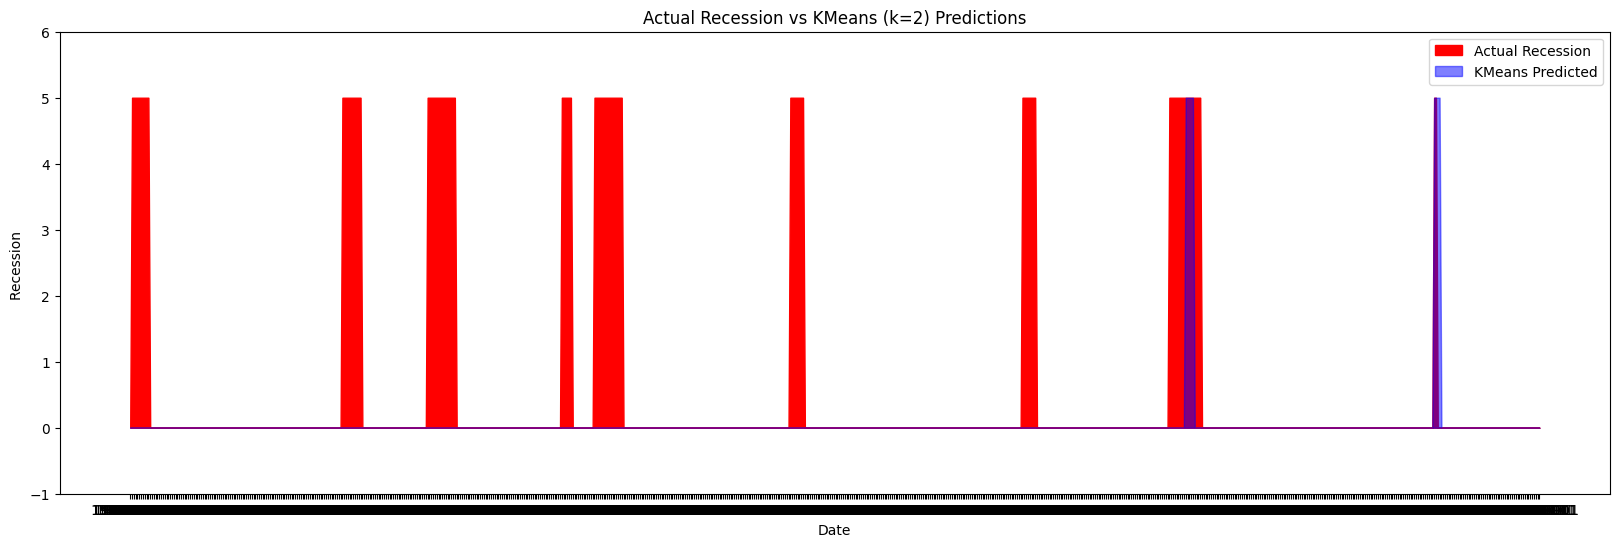

In [ ]:
plt.figure(figsize=(20,6))
plt.ylim([-1, 6])

# Actual recession periods (scaled for visibility)
plt.fill_between(merged_data.index, merged_data.USREC * 5, color="red", label="Actual Recession")

# KMeans predicted values (assumed to be 0 or 1, or possibly cluster labels)
#plt.plot(X_merged.index, X_merged['KMean_Pred'], color="blue", label="KMeans Predicted")#, linewidth=2)
plt.fill_between(X_merged.index, X_merged['KMeans_2_s']*5, color="blue", alpha=0.5, label="KMeans Predicted")
# Optional: Add titles and labels
plt.title("Actual Recession vs KMeans (k=2) Predictions")
plt.xlabel("Date")
plt.ylabel("Recession ")
plt.legend()
plt.grid(False)

plt.show()

In [ ]:
print("classification report Kmeans k=4: Cluster")
print(classification_report(y_merged, X_merged['KMean_Pred_4_S']))
print("classification report Kmeans k=2:")
print(classification_report(y_merged, X_merged['KMeans_2_s']))


classification report Kmeans k=4: Cluster
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       683
           1       0.59      0.99      0.74        95

    accuracy                           0.91       778
   macro avg       0.79      0.95      0.84       778
weighted avg       0.95      0.91      0.92       778

classification report Kmeans k=2:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       683
           1       0.78      0.07      0.13        95

    accuracy                           0.88       778
   macro avg       0.83      0.54      0.54       778
weighted avg       0.87      0.88      0.84       778



In [ ]:
yRec_count = y_merged.value_counts()
print(yRec_count)

USREC
0    683
1     95
Name: count, dtype: int64


In [ ]:
cluster_count_kmean = X_merged['KMean_Pred_4_S'].value_counts()
print(cluster_count_kmean)

KMean_Pred_4_S
0    618
1    160
Name: count, dtype: int64


## <font color=blue>DBSCAN

### <font color=red>How many clusters?

Requires the use of an Epsilon value

#### Plot Distance to Neighbors

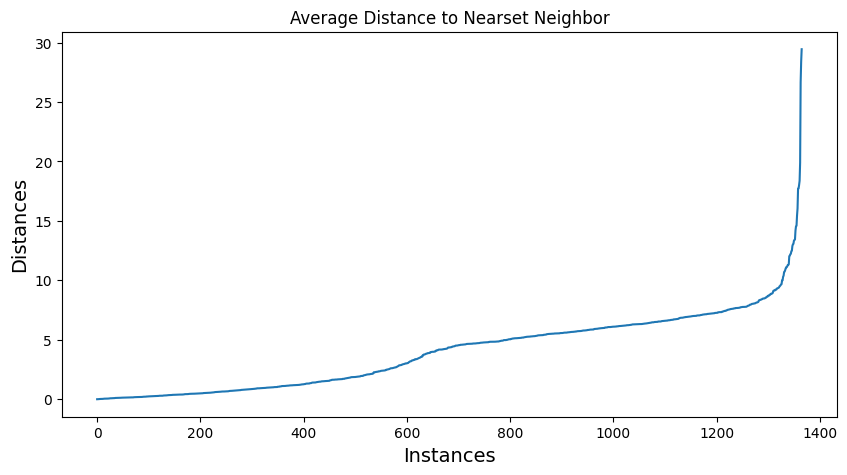

In [ ]:
#But how to determine a good epsilon?
#one method is to review the Avg. Distances to Nearest Neighbor graph and find its "elbow point"
nn_avg_distance(X_s)

In [ ]:
#And then once you know the range for your epsilon, use a loop to try out a few values
for epsilon in np.arange(1, 15):
    dbscan = DBSCAN(eps=epsilon, min_samples=5)      #epsilon defines the neighborhood distance # default min_smaples is 5 according to documentation
    dbscan.fit(X_s)
    print(epsilon, "-", np.unique(dbscan.labels_))

1 - [-1  0  1  2  3  4  5  6  7  8  9 10 11]
2 - [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35]
3 - [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
4 - [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28]
5 - [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
6 - [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
7 - [-1  0  1  2  3  4  5]
8 - [-1  0  1  2  3]
9 - [-1  0  1  2]
10 - [-1  0]
11 - [-1  0  1]
12 - [-1  0]
13 - [-1  0]
14 - [-1  0]


### Build Model and Predict

Defines clusters using continuous regions of high density but not able to predict

In [ ]:
# for epsilon in np.arange(6, 10):
#     dbscan = DBSCAN(eps=epsilon, min_samples=5)      #epsilon defines the neighborhood distance # default min_smaples is 5 according to documentation
#     dbscan.fit_predict(X_s)

In [ ]:
#create and fit the model
dbscan = DBSCAN(eps= 7, min_samples= 5)      #epsilon defines the neighborhood distance
y_dbscan = dbscan.fit(X_s)
X_merged['DBScan_eps7'] = y_dbscan.labels_[:778]
y_pred_dbscan = y_dbscan.labels_

In [ ]:
#see how many clusters are created
#NOTE that cluster -1 is for all outliers/anomalies
clusters = np.unique(y_pred_dbscan)
clusters
print(len(clusters))

7


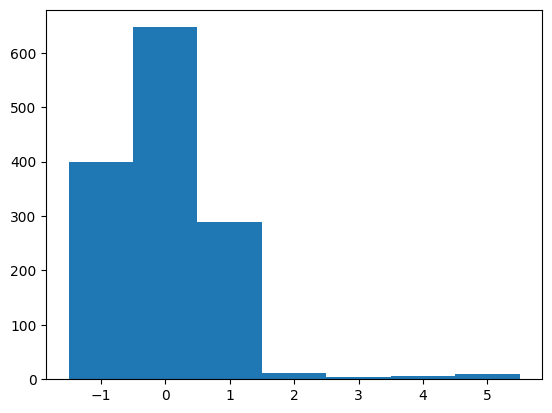

In [ ]:
#plot the number of instances in each of the created clusters
plt.hist(y_pred_dbscan, bins=range(-1,len(clusters)), align='left' )
plt.show()

### Analyze Clusters

In [ ]:
num_outliers = np.sum(y_pred_dbscan == -1)
print(f"Number of outliers: {num_outliers}")

Number of outliers: 399


In [ ]:
cluster_count_db = X_merged['DBScan_eps7'].value_counts()
print(cluster_count_db)

DBScan_eps7
-1    374
 1    289
 0     97
 2     11
 3      5
 4      1
 5      1
Name: count, dtype: int64


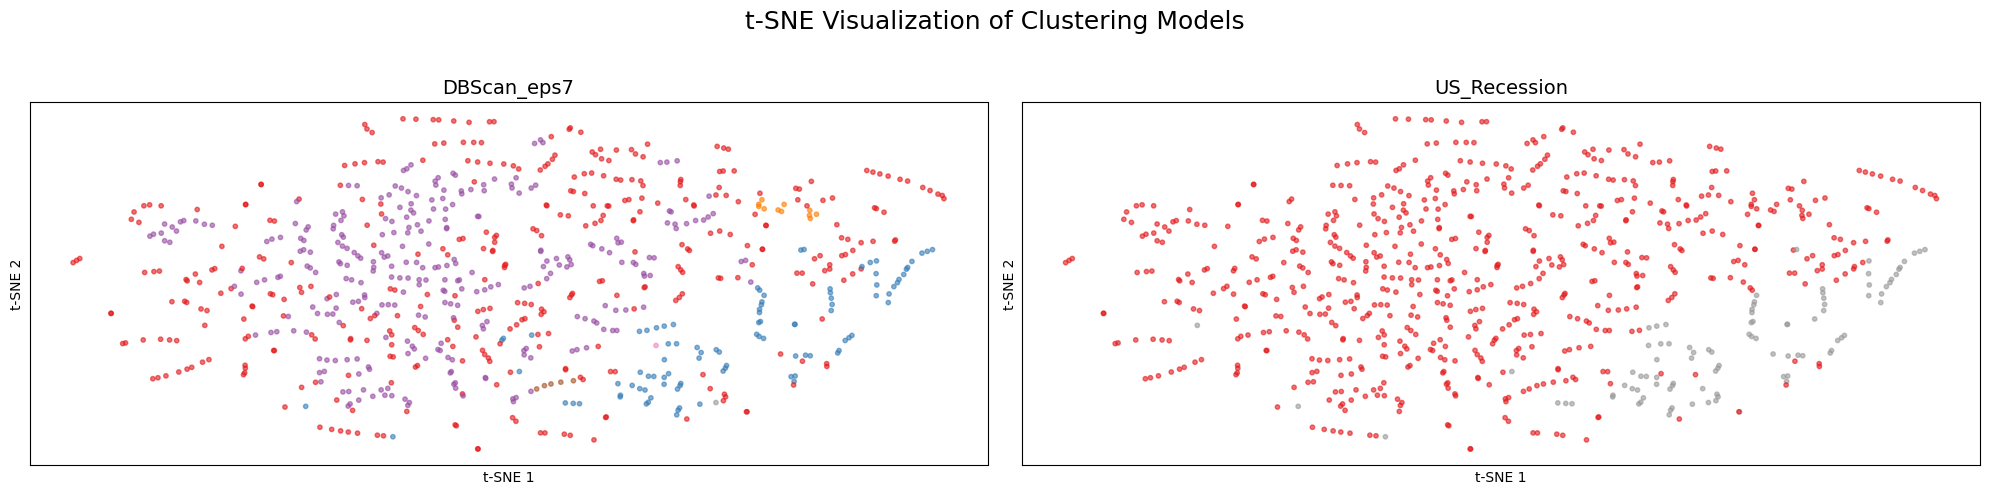

In [ ]:
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

# Define all clustering labels and titles
cluster_results = {
    "DBScan_eps7": X_merged['DBScan_eps7'],
    "US_Recession": y_merged
}

# Create subplots
plt.figure(figsize=(20, 5))

for i, (title, labels) in enumerate(cluster_results.items(), 1):
    plt.subplot(1, 2, i)

    color_map = {
    0: '#1f77b4',  # tab:blue
    1: '#d62728'   # tab:red
    }

    # Convert label array to color list
    color_list = labels.map(color_map)
    # scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color_list, s=10, alpha=0.6)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap= 'Set1', s=10, alpha=0.6)
    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.xticks([])
    plt.yticks([])

plt.suptitle("t-SNE Visualization of Clustering Models", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<ipython-input-46-396d1bbad0d0>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_labels)) # Using Set1 colormap


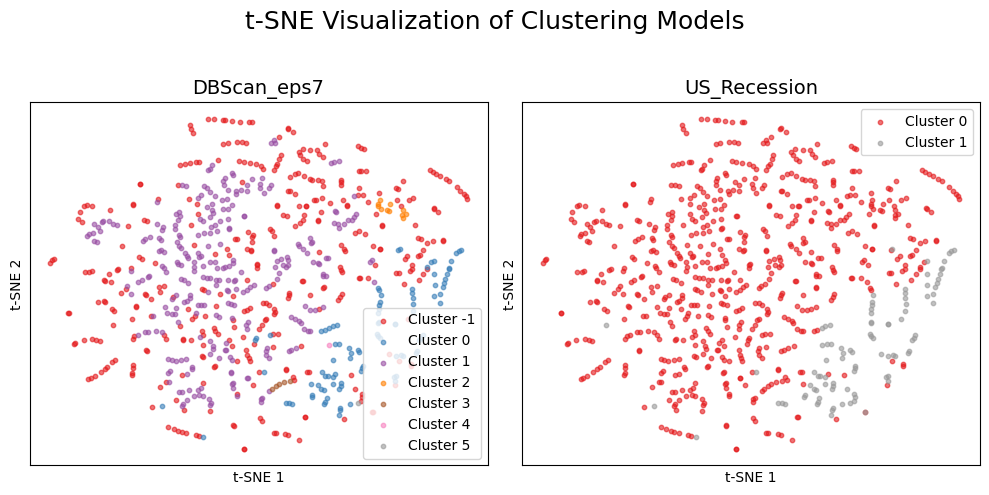

In [ ]:
# prompt: how can I know what cluster equates the light blue color in the DBScan_eps 7 plot ?

import matplotlib.pyplot as plt
import numpy as np

# Assuming X_tsne and X_merged['DBScan_eps7'] are defined from your provided code

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

# Define all clustering labels and titles
cluster_results = {
    "DBScan_eps7": X_merged['DBScan_eps7'],
    "US_Recession": y_merged
}

# Create subplots
plt.figure(figsize=(10, 5))

for i, (title, labels) in enumerate(cluster_results.items(), 1):
    plt.subplot(1, 2, i)

    # Unique cluster labels including -1 for noise
    unique_labels = np.unique(labels)

    # Create a color map for the clusters
    cmap = plt.cm.get_cmap('Set1', len(unique_labels)) # Using Set1 colormap

    for label_idx, label in enumerate(unique_labels):
      cluster_points = X_tsne[labels == label]
      plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cmap(label_idx), label=f"Cluster {label}", s=10, alpha=0.6)

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend() # Show the legend
    plt.xticks([])
    plt.yticks([])

plt.suptitle("t-SNE Visualization of Clustering Models", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
X_merged['DBScan_Pred_eps7'] = 0
X_merged.loc[X_merged['DBScan_eps7'] == 0, 'DBScan_Pred_eps7'] = 1

X_merged.head()


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,KMeans_4_S,KMean_Pred_4_S,KMeans_2_s,DBScan_eps7,DBScan_Pred_eps7
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-04-01,0.217000,0.181274,1.144257,-0.125883,0.963593,-0.852720,-0.226793,-0.114339,-0.113860,-1.146860,...,2.203269,0.996106,0.829600,-1.758171,NaN,1,1,0,-1,0
1960-05-01,0.259227,0.232293,0.302686,-1.616331,0.326743,-0.598588,0.152058,0.229604,0.460786,-0.387620,...,-2.233333,1.248423,0.978035,-0.750197,NaN,1,1,0,0,1
1960-06-01,0.221856,0.194058,-0.176169,-0.434232,0.317915,-0.717204,-0.114302,-0.114865,0.191831,-0.079024,...,-2.233333,1.560265,1.350750,-0.159934,NaN,1,1,0,-1,0
1960-07-01,0.165743,0.137180,-0.612332,-0.979686,-0.872057,-0.570900,-0.380445,-0.344476,-0.342849,-1.306322,...,-2.233333,1.191418,1.422327,0.713661,NaN,1,1,0,0,1
1960-08-01,0.031939,-0.028673,0.029163,0.014053,-0.267219,-0.571412,-0.643178,-0.570153,-0.454503,-1.254916,...,1.393355,0.903601,1.485908,0.648432,NaN,1,1,0,0,1


<ipython-input-48-a4ef3db321fb>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_labels)) # Using Set1 colormap


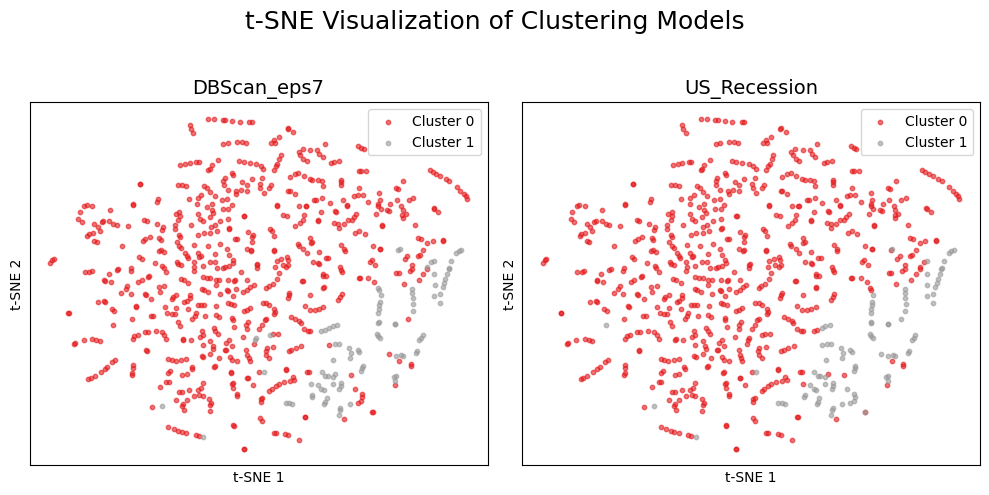

In [ ]:
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

# Define all clustering labels and titles
cluster_results = {
    "DBScan_eps7": X_merged['DBScan_Pred_eps7'],
    "US_Recession": y_merged
}

# Create subplots
plt.figure(figsize=(10, 5))

for i, (title, labels) in enumerate(cluster_results.items(), 1):
    plt.subplot(1, 2, i)

    # Unique cluster labels including -1 for noise
    unique_labels = np.unique(labels)

    # Create a color map for the clusters
    cmap = plt.cm.get_cmap('Set1', len(unique_labels)) # Using Set1 colormap

    for label_idx, label in enumerate(unique_labels):
      cluster_points = X_tsne[labels == label]
      plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cmap(label_idx), label=f"Cluster {label}", s=10, alpha=0.6)

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend() # Show the legend
    plt.xticks([])
    plt.yticks([])

plt.suptitle("t-SNE Visualization of Clustering Models", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
print(classification_report(y_merged, X_merged['DBScan_Pred_eps7']))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       683
           1       0.88      0.89      0.89        95

    accuracy                           0.97       778
   macro avg       0.93      0.94      0.93       778
weighted avg       0.97      0.97      0.97       778



## <font color=blue>Agglomorative Clustering (skipped for now)

#### Build Model and Predict

In [ ]:
#create the model and allow it to determine number of clusters
agg = AgglomerativeClustering(n_clusters = 3 ) #can leave off clusters too
y_pred_agg = agg.fit_predict(X)

In [ ]:
#see the number of clusters created
y_pred_agg

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

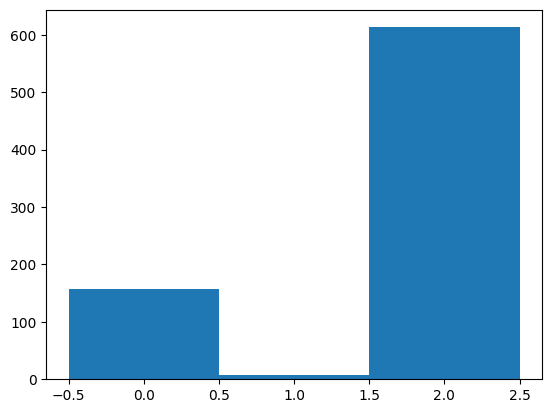

In [ ]:
#plot the number of instances in each of the created clusters
plt.hist(y_pred_agg, bins=range(len(set(y_pred_agg))+1), align='left' )
plt.show()

#### Analyze Clusters

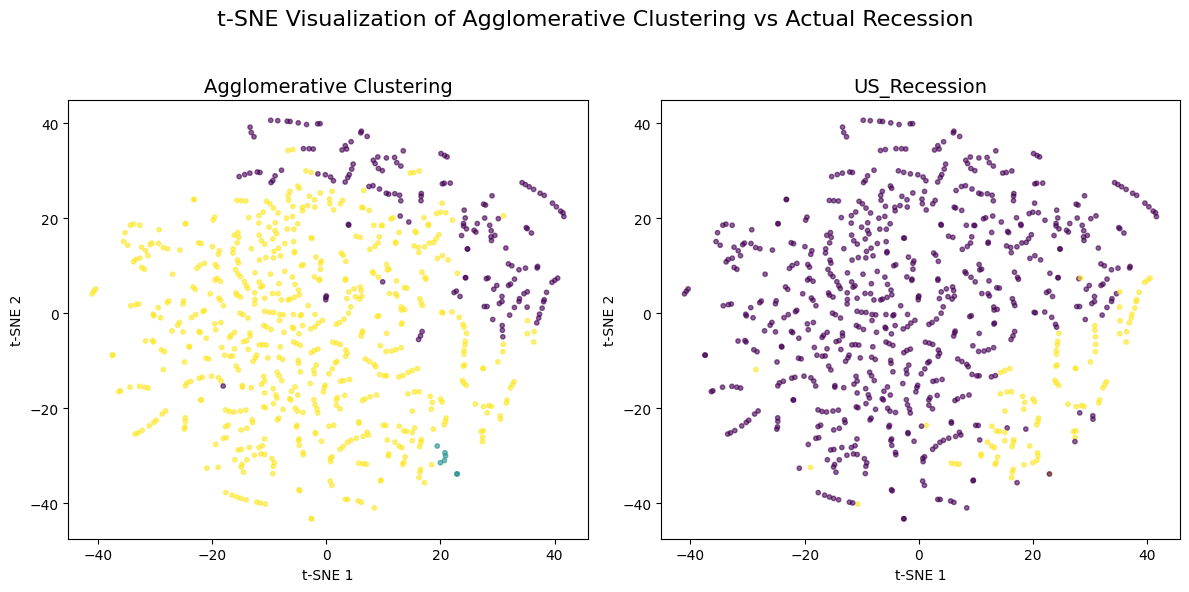

In [ ]:
# plot tsne for agglomerative and actual recession values

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

# Assuming 'y_pred_agg' from the Agglomerative Clustering is available
cluster_results = {
    "Agglomerative Clustering": y_pred_agg,
    "US_Recession": y_merged
}

plt.figure(figsize=(12, 6))

for i, (title, labels) in enumerate(cluster_results.items(), 1):
    plt.subplot(1, 2, i)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, s=10, alpha=0.6)
    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

plt.suptitle("t-SNE Visualization of Agglomerative Clustering vs Actual Recession", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## <font color=blue>Gaussian Mixture

Using a probalistic model that clusters based on instances having similar Gaussian (i.e. normal) distribution

### <font color=red>How many clusters?

### Build Model and Predict

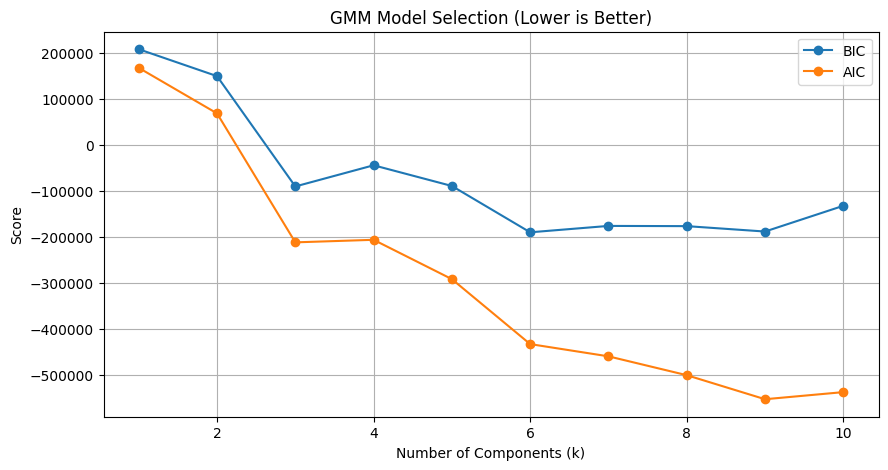

In [ ]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

bic = []
aic = []
k_range = range(1, 11)

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_s)  # Or X if you're doing it on original
    bic.append(gmm.bic(X_s))
    aic.append(gmm.aic(X_s))

# Plotting
plt.figure(figsize=(10,5))
plt.plot(k_range, bic, label='BIC', marker='o')
plt.plot(k_range, aic, label='AIC', marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('Score')
plt.title('GMM Model Selection (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()


###### Tried k = 6 based on the graph above

In [ ]:
#the most likely cluster (hard clustering) predictions made
#Let's train a Gaussian Mixture on this dataset.
k = 6
gauss_6 = GaussianMixture(n_components=k, random_state=42)
y_pred_gm_6 = gauss_6.fit_predict(X_s)
X_merged["Gaussian_Mixture_6"] = y_pred_gm_6[:778]

### Analyze Clusters

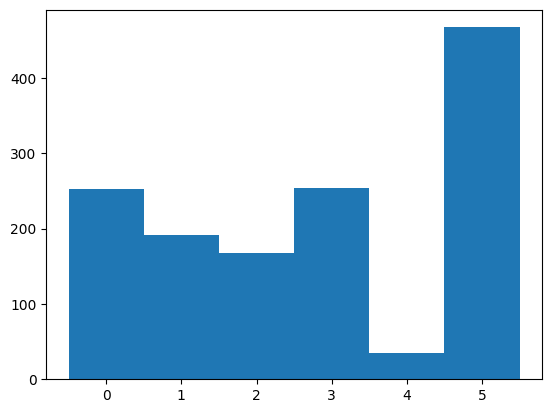

In [ ]:
#plot the number of instances in each of the created clusters
plt.hist(y_pred_gm_6, bins=range(len(set(y_pred_gm_6))+1), align='left')
plt.show()

<ipython-input-57-4d4bd34a32b6>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_labels)) # Using Set1 colormap


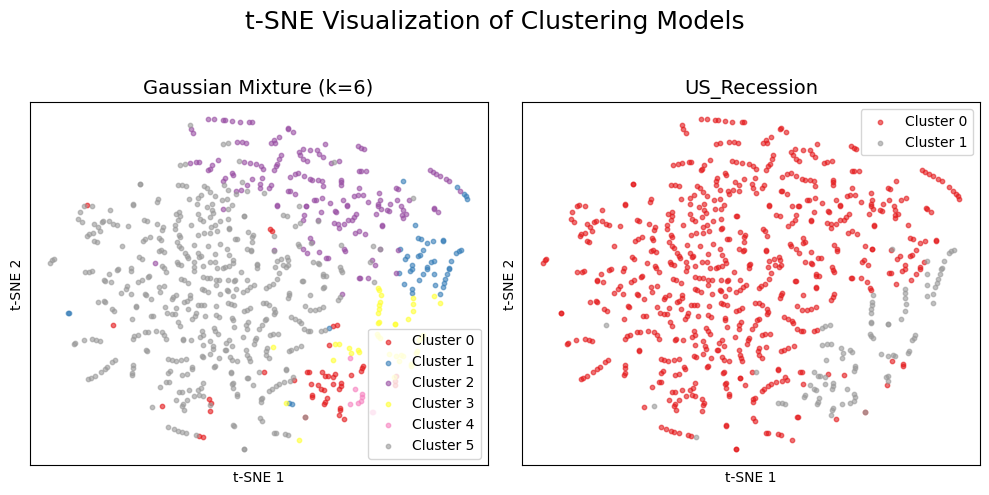

In [ ]:
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

# Define all clustering labels and titles
cluster_results = {
    "Gaussian Mixture (k=6)": X_merged["Gaussian_Mixture_6"],
   # "Gaussian Mixture (k=4)": X_merged["Gaussian_Mixture_4"],
    "US_Recession": y_merged
}

# Create subplots
# Create subplots
plt.figure(figsize=(10, 5))

for i, (title, labels) in enumerate(cluster_results.items(), 1):
    plt.subplot(1, 2, i)

    # Unique cluster labels including -1 for noise
    unique_labels = np.unique(labels)

    # Create a color map for the clusters
    cmap = plt.cm.get_cmap('Set1', len(unique_labels)) # Using Set1 colormap

    for label_idx, label in enumerate(unique_labels):
      cluster_points = X_tsne[labels == label]
      plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cmap(label_idx), label=f"Cluster {label}", s=10, alpha=0.6)

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend() # Show the legend
    plt.xticks([])
    plt.yticks([])

plt.suptitle("t-SNE Visualization of Clustering Models", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Cluster 0,1,3,4 seems to be recessions data
X_merged['Gaussian_Mixture_Pred_6'] = 0
X_merged.loc[X_merged['Gaussian_Mixture_6'] == 0, 'Gaussian_Mixture_Pred_6'] = 1
X_merged.loc[X_merged['Gaussian_Mixture_6'] == 1, 'Gaussian_Mixture_Pred_6'] = 1

X_merged.loc[X_merged['Gaussian_Mixture_6'] == 3, 'Gaussian_Mixture_Pred_6'] = 1
X_merged.loc[X_merged['Gaussian_Mixture_6'] == 4, 'Gaussian_Mixture_Pred_6'] = 1

<ipython-input-59-906c89a2a45b>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_labels)) # Using Set1 colormap


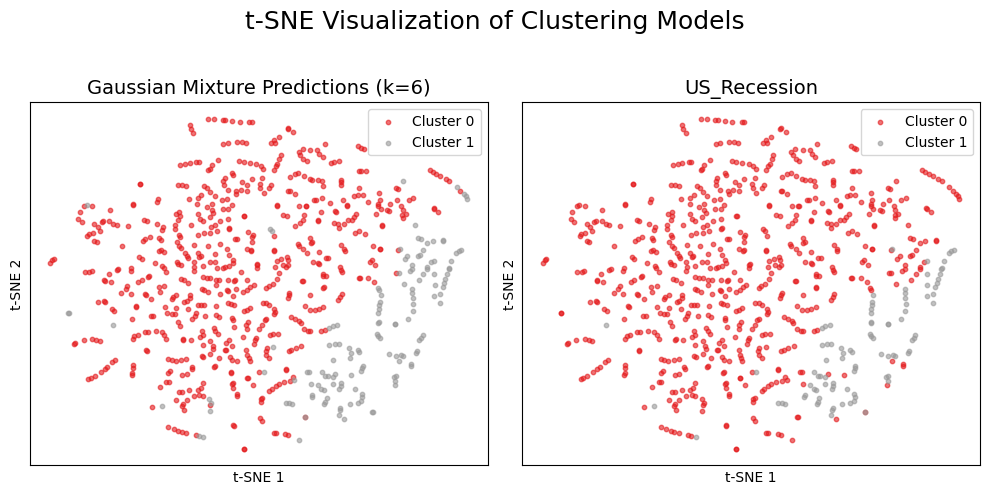

In [ ]:
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

# Define all clustering labels and titles
cluster_results = {
    "Gaussian Mixture Predictions (k=6)": X_merged["Gaussian_Mixture_Pred_6"],
    "US_Recession": y_merged
}

# Create subplots
plt.figure(figsize=(10, 5))

for i, (title, labels) in enumerate(cluster_results.items(), 1):
    plt.subplot(1, 2, i)

    # Unique cluster labels including -1 for noise
    unique_labels = np.unique(labels)

    # Create a color map for the clusters
    cmap = plt.cm.get_cmap('Set1', len(unique_labels)) # Using Set1 colormap

    for label_idx, label in enumerate(unique_labels):
      cluster_points = X_tsne[labels == label]
      plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cmap(label_idx), label=f"Cluster {label}", s=10, alpha=0.6)

    plt.title(title, fontsize=14)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend() # Show the legend
    plt.xticks([])
    plt.yticks([])

plt.suptitle("t-SNE Visualization of Clustering Models", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Gaussian_Mixture_Pred_4_Combined: Combined clusters 0 and 1 and mapped them to USRec = 1

In [ ]:
print("classification report Kmeans k=6 : Clusters 0,1,3,4 combined and Mapped to recession 1")
print(classification_report(y_merged, X_merged['Gaussian_Mixture_Pred_6']))


classification report Kmeans k=6 : Clusters 0,1,3,4 combined and Mapped to recession 1
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       683
           1       0.64      1.00      0.78        95

    accuracy                           0.93       778
   macro avg       0.82      0.96      0.87       778
weighted avg       0.96      0.93      0.94       778



In [ ]:
X_merged.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DTCTHFNM,INVEST,VIXCLSx,KMeans_4_S,KMean_Pred_4_S,KMeans_2_s,DBScan_eps7,DBScan_Pred_eps7,Gaussian_Mixture_6,Gaussian_Mixture_Pred_6
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-04-01,0.217000,0.181274,1.144257,-0.125883,0.963593,-0.852720,-0.226793,-0.114339,-0.113860,-1.146860,...,0.829600,-1.758171,NaN,1,1,0,-1,0,5,0
1960-05-01,0.259227,0.232293,0.302686,-1.616331,0.326743,-0.598588,0.152058,0.229604,0.460786,-0.387620,...,0.978035,-0.750197,NaN,1,1,0,0,1,0,1
1960-06-01,0.221856,0.194058,-0.176169,-0.434232,0.317915,-0.717204,-0.114302,-0.114865,0.191831,-0.079024,...,1.350750,-0.159934,NaN,1,1,0,-1,0,0,1
1960-07-01,0.165743,0.137180,-0.612332,-0.979686,-0.872057,-0.570900,-0.380445,-0.344476,-0.342849,-1.306322,...,1.422327,0.713661,NaN,1,1,0,0,1,0,1
1960-08-01,0.031939,-0.028673,0.029163,0.014053,-0.267219,-0.571412,-0.643178,-0.570153,-0.454503,-1.254916,...,1.485908,0.648432,NaN,1,1,0,0,1,0,1


In [ ]:
# compare the results to USREC (y_merged)
selected_columns = ['KMean_Pred_4_S', 'KMeans_2_s','DBScan_Pred_eps7',
                    'Gaussian_Mixture_Pred_6',
                    ]

combined_df = X_merged[selected_columns].copy()
combined_df['USRec'] = y_merged.values


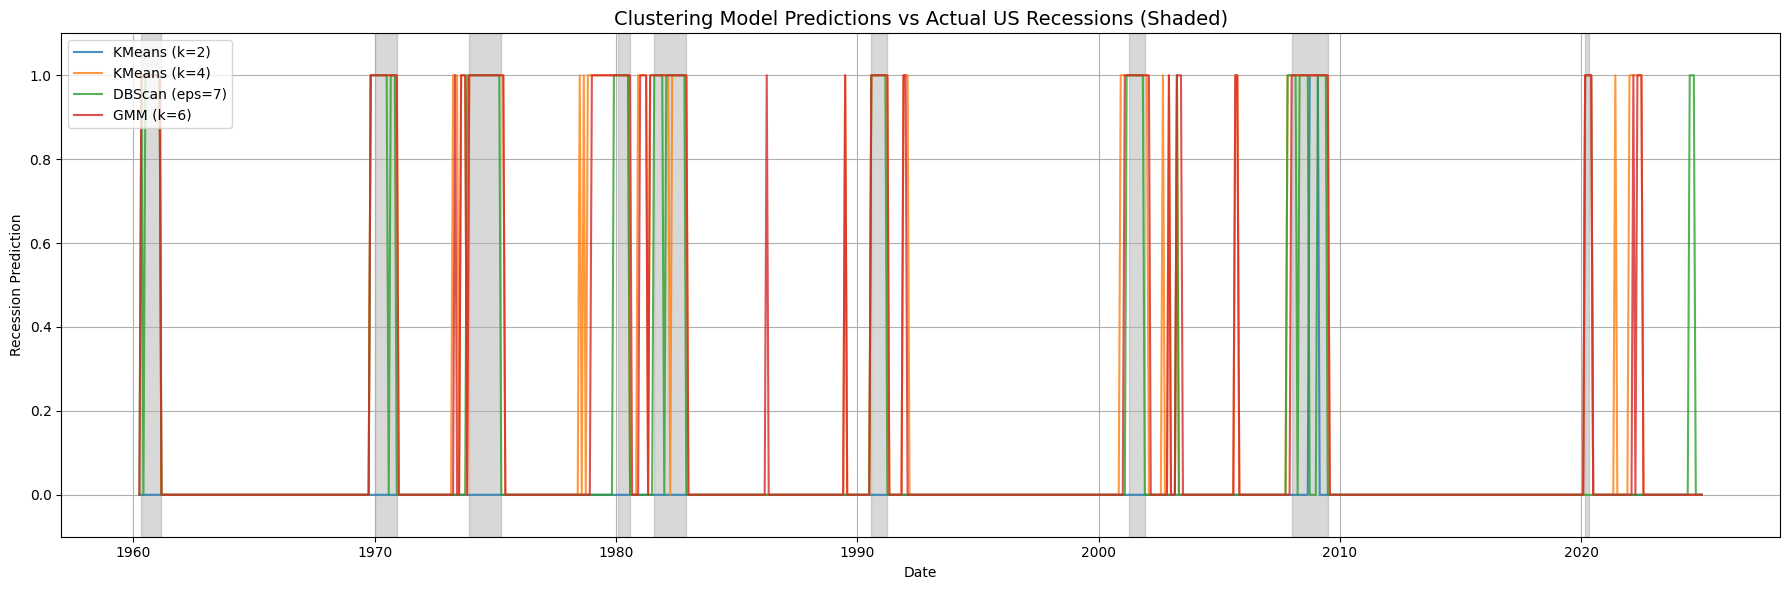

In [ ]:
#Comparing all of our models to the actual US recession periods
# Ensure datetime index
combined_df.index = pd.to_datetime(combined_df.index)

# Start a figure
plt.figure(figsize=(18, 6))
ax = plt.gca()

# Step 1: Shade actual recession periods
recession = combined_df['USRec']
in_recession = False
start_date = None

for date, value in recession.items():
    if value == 1 and not in_recession:
        start_date = date
        in_recession = True
    elif value == 0 and in_recession:
        ax.axvspan(start_date, date, color='grey', alpha=0.3)
        in_recession = False
if in_recession:  # handle if it ends in a recession
    ax.axvspan(start_date, combined_df.index[-1], color='grey', alpha=0.3)

# Step 2: Plot each model prediction
ax.plot(combined_df.index, combined_df['KMeans_2_s'], label='KMeans (k=2)', alpha=0.8)
ax.plot(combined_df.index, combined_df['KMean_Pred_4_S'], label='KMeans (k=4)', alpha=0.8)
ax.plot(combined_df.index, combined_df['DBScan_Pred_eps7'], label='DBScan (eps=7)', alpha=0.8)
ax.plot(combined_df.index, combined_df['Gaussian_Mixture_Pred_6'], label='GMM (k=6)', alpha=0.8)
#ax.plot(combined_df.index, combined_df['Gaussian_Mixture_Pred_4_Combined'], label='GMM (k=4, Combined)', alpha=0.8)

# Step 3: Styling
ax.set_title('Clustering Model Predictions vs Actual US Recessions (Shaded)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Recession Prediction')
ax.legend(loc='upper left')
ax.set_ylim(-0.1, 1.1)
ax.grid(True)
plt.tight_layout()

plt.show()
